## Wave equation
#### Parameter estimation for the Wave Equation using Gaussian processes (Without temporal discretization since we'd need a second order time scheme)


#### Problem Setup

$u_{tt} - c u_{xx} = 0$

General solution:
$u(x,t) = F(x-ct) + G(x+ct)$ with F, G some functions.

Take $F(x) = x^2$ and $G(x) = \sin(x)$ and $c=1$.

Thus: $u(x,t) = (x-t)^2 + \sin(x + t)$.

$x \in [0, 1], t \in [0,1]$

Set $f = 0$.

Consider $u$ to be a Gaussian process.

$u \sim \mathcal{GP}(0, k_{uu}(x_i, x_j, \theta))$

And the linear operator:

$\mathcal{L}_x^c = \frac{d^2}{dt^2} \cdot - c \frac{d^2}{dx^2} \cdot$

so that

$\mathcal{L}_x^c u = f$

Problem at hand: estimate $c$ (should be $c = 1$ in the end).


#### step 1: Simulate data

In [45]:
import time
import numpy as np
import sympy as sp
import math
import warnings
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [46]:
n = 10
np.random.seed(int(time.time()))
t = np.random.rand(n)
x = np.random.rand(n)

In [47]:
y_u = np.multiply(x-t, x-t) + np.sin(x+t)
y_f = 0*x

#### Step 2:Evaluate kernels

$k_{uu}(x_i, x_j; \theta) = \theta exp(-\frac{1}{2l_x}(x_i-x_j)^2 - \frac{1}{2l_t}(t_i-t_j)^2)$

In [48]:
x_i, x_j, t_i, t_j, theta, l_x, l_t, c = sp.symbols('x_i x_j t_i t_j theta l_x l_t c')
kuu_sym = theta*sp.exp(-1/(2*l_x)*((x_i - x_j)**2) - 1/(2*l_t)*((t_i - t_j)**2))
kuu_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta, l_x, l_t), kuu_sym, "numpy")
def kuu(x, t, theta, l_x, l_t):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kuu_fn(x[i], x[j], t[i], t[j], theta, l_x, l_t)
    return k

$k_{ff}(x_i,x_j;\theta,\phi) \\
= \mathcal{L}_{\tilde{x}_i}^c \mathcal{L}_{\tilde{x}_j}^c k_{uu}(x_i, x_j; \theta) \\
= \frac{d^4}{dt_i^2 dt_j^2}k_{uu} - c\frac{d^4}{dt_i^2 dx_j^2}k_{uu} - c\frac{d^4}{dx_i^2 dt_j^2}k_{uu} + c^2\frac{d^4}{dx_i^2 dx_j^2}k_{uu}$

In [49]:
kff_sym = sp.diff(kuu_sym, t_i, t_i, t_j, t_j) \
        - c*sp.diff(kuu_sym, t_i, t_i, x_j, x_j) \
        - c*sp.diff(kuu_sym, x_i, x_i, t_j, t_j) \
        + c**2*sp.diff(kuu_sym, x_i, x_i, x_j, x_j)
kff_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta, l_x, l_t, c), kff_sym, "numpy")
def kff(x, t, theta, l_x, l_t, c):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kff_fn(x[i], x[j], t[i], t[j], theta, l_x, l_t, c)
    return k

$k_{fu}(x_i,x_j;\theta,\phi) \\
= \mathcal{L}_{\tilde{x}_i}^c k_{uu}(x_i, x_j; \theta) \\
= \frac{d^2}{dt_i^2}k_{uu} - c\frac{d^2}{dx_i^2}k_{uu}$

In [50]:
kfu_sym = sp.diff(kuu_sym, t_i, t_i) - c*sp.diff(kuu_sym, x_i, x_i)
kfu_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta, l_x, l_t, c), kfu_sym, "numpy")
def kfu(x, t, theta, l_x, l_t, c):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kfu_fn(x[i], x[j], t[i], t[j], theta, l_x, l_t, c)
    return k

In [51]:
def kuf(x, t, theta, l_x, l_t, c):
    return kfu(x, t, theta, l_x, l_t, c).T

#### Step 3: Compute NLML

In [52]:
def nlml(params, x, t, y1, y2, s):
    theta_exp = np.exp(params[0]) 
    l_x_exp = np.exp(params[1])
    l_t_exp = np.exp(params[2]) # params[3] = c
    K = np.block([
        [kuu(x, t, theta_exp, l_x_exp, l_t_exp) + s*np.identity(x.size), kuf(x, t, theta_exp, l_x_exp, l_t_exp, params[3])],
        [kfu(x, t, theta_exp, l_x_exp, l_t_exp, params[3]), kff(x, t, theta_exp, l_x_exp, l_t_exp, params[3]) + s*np.identity(x.size)]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

In [53]:
def nlml(params, x, t, y1, y2, s):
    p0 = np.exp(params[0])
    p1 = np.exp(params[1])
    p2 = np.exp(params[2])
    K = np.block([
        [kuu(x, t, p0, p1, p2) + s*np.identity(x.size), kuf(x, t, p0, p1, p2, params[3])],
        [kfu(x, t, p0, p1, p2, params[3]), kff(x, t, p0, p1, p2, params[3]) + s*np.identity(x.size)]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

#### Step 4: Optimise hyperparameters

In [54]:
# m = minimize(nlml, np.random.rand(4), args=(x, t, y_u, y_f, 1e-3), method="Nelder-Mead", options = {'maxiter' : 1000})

In [55]:
# Want to define a nice sequence of numbers, that won't increase too quickly.
def fib_formula(n):
    golden_ratio = (1+math.sqrt(5))/2
    val = (golden_ratio**n - (1-golden_ratio)**n) / math.sqrt(5)
    return int(round(val))

In [56]:
def minimize_restarts(x,t,y_u,y_f,n=10): 
    nlml_wp = lambda params: nlml(params, x, t, y_u, y_f, 1e-7)
    all_results = []
    for it in range(0,n):
        try:
            all_results.append(minimize(nlml_wp, fib_formula(it+1)*np.random.rand(4), method="Nelder-Mead", options={'maxiter':5000, 'fatol':0.001}))
        except np.linalg.LinAlgError:
            pass
    filtered_results = [m for m in all_results if 0==m.status]
    function_values = [m.fun for m in filtered_results]
    return (min(filtered_results, key = lambda x: x.fun), function_values)

 final_simplex: (array([[4.86645347, 2.24557135, 2.26801076, 0.99941617],
       [4.86645827, 2.24557443, 2.26800613, 0.99941624],
       [4.86640334, 2.24555928, 2.26798639, 0.99941623],
       [4.86643431, 2.24556428, 2.26800092, 0.99941608],
       [4.86643649, 2.24557204, 2.26800084, 0.99941611]]), array([-49.65683717, -49.65683673, -49.65683669, -49.65683662,
       -49.65683637]))
           fun: -49.656837169347604
       message: 'Optimization terminated successfully.'
          nfev: 670
           nit: 390
        status: 0
       success: True
             x: array([4.86645347, 2.24557135, 2.26801076, 0.99941617])


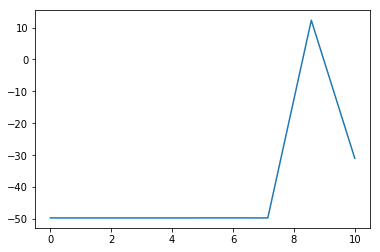

In [57]:
repeats = 10
warnings.filterwarnings("ignore") # Suppressing warnings
(m, function_values) = minimize_restarts(x, t, y_u, y_f, repeats)
print(m)

# This plot will show us how frail our model is w.r.t. the initial values
lin = np.linspace(0, repeats, len(function_values))
plt.plot(lin, function_values)  
plt.show()

In [58]:
m.x[3] # This is our predicted value for c

0.9994161659419571

Plotting by varying theta:

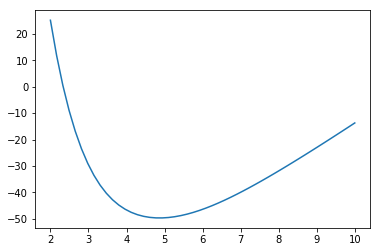

In [67]:
lin = np.linspace(2, 10, 50)
res = [nlml((q, m.x[1], m.x[2], m.x[3]), x, t, y_u, y_f, 1e-7) for q in lin]
plt.plot(lin, res)
# nlml((4.8159, 0.4641, 4.4104, 0.006), x, t, y_u, y_f, 1e-3)

Plotting by varying l_x:

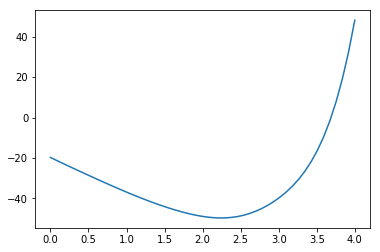

In [69]:
lin = np.linspace(0, 4, 50)
res = [nlml((m.x[0], q, m.x[2], m.x[3]), x, t, y_u, y_f, 1e-7) for q in lin]
plt.plot(lin, res)
# nlml((4.8159, 0.4641, 4.4104, 0.006), x, t, y_u, y_f, 1e-3)

Plotting by varying l_t:

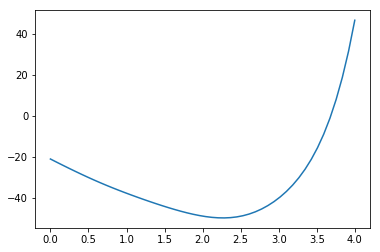

In [68]:
lin = np.linspace(0, 4, 50)
res = [nlml((m.x[0], m.x[1], q, m.x[3]), x, t, y_u, y_f, 1e-7) for q in lin]
plt.plot(lin, res)
# nlml((4.8159, 0.4641, 4.4104, 0.006), x, t, y_u, y_f, 1e-3)

Plotting by varying c:

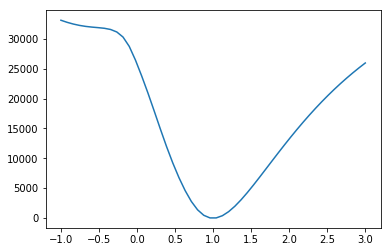

In [64]:
lin = np.linspace(-1, 3, 50)
res = [nlml((m.x[0], m.x[1], m.x[2], q), x, t, y_u, y_f, 1e-7) for q in lin]
plt.plot(lin, res)
# nlml((4.8159, 0.4641, 4.4104, 0.006), x, t, y_u, y_f, 1e-3)